# `MonotonicSplineEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import math
import random
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 25  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 25 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATC


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

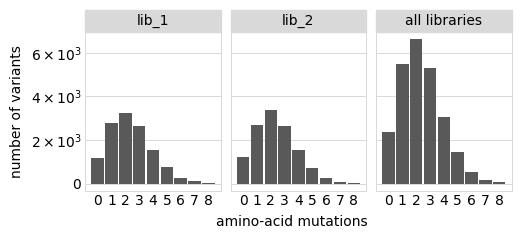

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

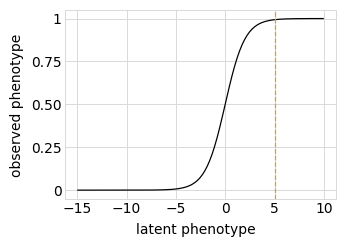

In [10]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

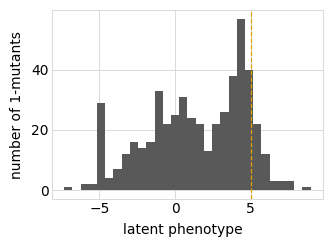

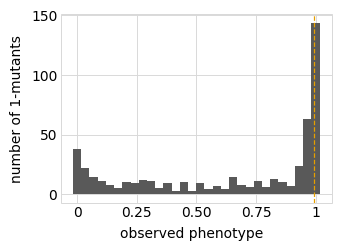

In [11]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

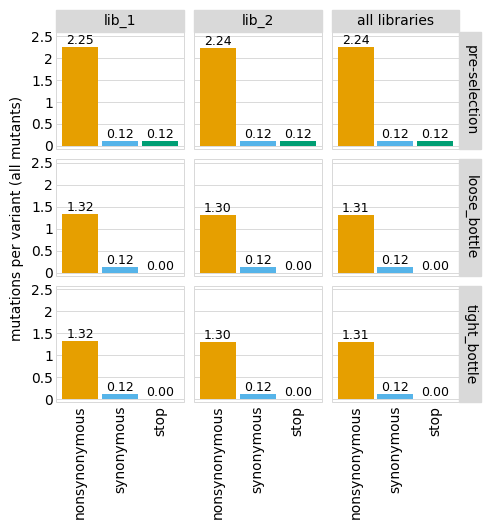

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,28149864,12500000,2.251989
1,lib_1,pre-selection,synonymous,1527283,12500000,0.122183
2,lib_1,pre-selection,stop,1479183,12500000,0.118335
3,lib_1,loose_bottle,nonsynonymous,16559375,12500000,1.324750
4,lib_1,loose_bottle,synonymous,1502767,12500000,0.120221
5,lib_1,loose_bottle,stop,6732,12500000,0.000539
6,lib_1,tight_bottle,nonsynonymous,16514215,12500000,1.321137
7,lib_1,tight_bottle,synonymous,1454304,12500000,0.116344
8,lib_1,tight_bottle,stop,6766,12500000,0.000541
9,lib_2,pre-selection,nonsynonymous,27971269,12500000,2.237702


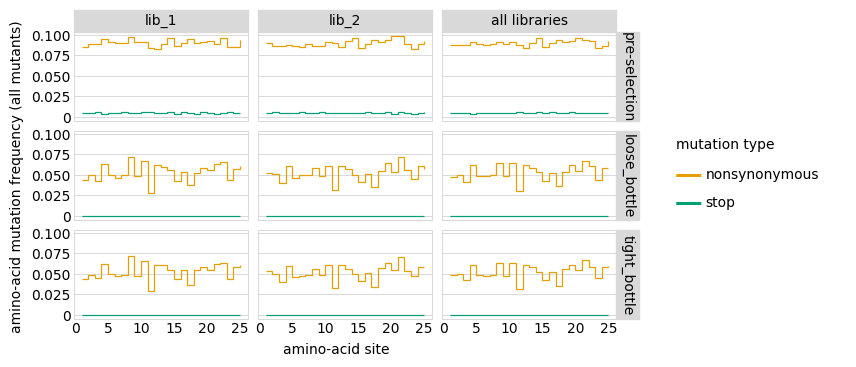

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

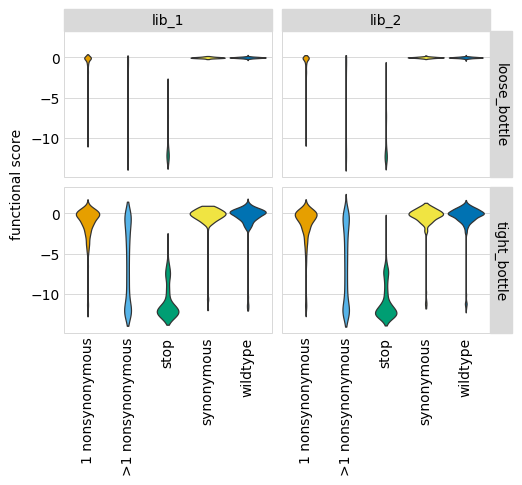

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize `MonotonicSplineEpistasis` model

Focus just on loose bottleneck for now:

In [20]:
func_scores = func_scores.query('post_sample == "loose_bottle"')

Make a binary map for the variants:

In [21]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 500


Now initialize the model:

In [22]:
spline_model = dms_variants.globalepistasis.MonotonicSplineEpistasis(binarymap)

Look at some model attributes:

In [23]:
spline_model.nparams

508

In [24]:
spline_model.epistasis_HOC

1.0

In [25]:
round(spline_model.loglik)

-1342284.0

In [26]:
spline_model.latent_phenotype_wt

0.0

In [27]:
for key, val in spline_model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -14.04
alpha_1: 2.89
alpha_2: 2.89
alpha_3: 2.89
alpha_4: 2.89
alpha_5: 2.89


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [28]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Initial least squares fitting
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [29]:
spline_model._fit_latent_leastsquares()
spline_model._rescale_latent_effects()

Re-check the gradients:

In [30]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

In [31]:
round(spline_model.loglik)

-70284.0

In [35]:
r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, 'observed')
        )
print(f"R = {r:.3f}, P = {p:.2g}")

R = 0.922, P = 0


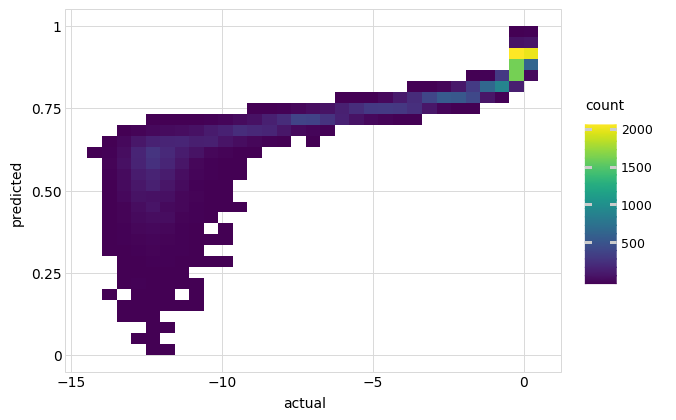

In [36]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': spline_model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
                   })

_ = (ggplot(df, aes('actual', 'predicted')) +
     geom_bin2d()
     ).draw()

In [ ]:
round(spline_model.epistasis_HOC, 3)

In [ ]:
round(spline_model.latent_phenotype_wt, 3)

Now fit the model by maximum likelihood:

In [ ]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
optres = spline_model.fit()
print(f"Fitting took {time.time() - start:.3f}")

In [ ]:
round(noepistasis_model.loglik)

In [ ]:
round(noepistasis_model.epistasis_HOC, 3)

In [ ]:
round(noepistasis_model.latent_phenotype_wt, 3)

In [ ]:
r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        noepistasis_model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
        )
print(f"R = {r:.3f}, P = {p:.2g}")

In [ ]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': noepistasis_model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
                   })

_ = (
     ggplot(df, aes('actual', 'predicted')) +
     geom_bin2d()
     ).draw()